### Initialization

In [ ]:
import librosa
import soundfile as sf
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "STIXGeneral"

import shutil
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import warnings
from copy import deepcopy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

warnings.filterwarnings("ignore")


def extract_mfcc(file_path, n_mfcc=13, hop_length=512, n_fft=2048):
    # Load audio file using soundfile
    audio, sr = sf.read(file_path)

    # Extract MFCC features
    mfccs = librosa.feature.mfcc(
        y=audio, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft
    )

    return mfccs


def process_timit_data(data_path, output_path):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # Process each TIMIT file
    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith(".WAV"):
                file_path = os.path.join(root, file)

                # Extract subfolder name from the TIMIT path
                subfolder_name = os.path.relpath(root, data_path)

                # Create subfolder in the output directory
                output_subfolder = os.path.join(output_path, subfolder_name)
                if not os.path.exists(output_subfolder):
                    os.makedirs(output_subfolder)

                # Extract MFCC features
                mfccs = extract_mfcc(file_path)

                # Save MFCC matrix in the subfolder
                output_file = os.path.join(
                    output_subfolder, os.path.splitext(file)[0] + "_mfcc.npy"
                )
                np.save(output_file, mfccs.T)

                print(f"Processed {file} and saved MFCC matrix to {output_file}")

timit_data_path = "./data/"
output_directory = "./output/"

# Skip this step if the data has already been processed
if not os.path.exists(output_directory):
    process_timit_data(timit_data_path, output_directory)

### Train-Test Split

In [ ]:
train_dir = "./train/"
test_dir = "./test/"

# Create output directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

folders = os.listdir(output_directory)[2:]

# For each folder in file_list, keep 80% of files in train directory and 20% in test directory
train_files = []
test_files = []

for folder in folders:
    files = glob(os.path.join(output_directory, folder, "*.npy"))
    split_index = int(0.8 * len(files))
    train_files.extend(files[:split_index])
    test_files.extend(files[split_index:])

if not os.path.exists(train_dir):
    os.makedirs(train_dir)
    # Copy files to train directory
    for file in train_files:
        subfolder_name = os.path.relpath(os.path.dirname(file), output_directory)
        output_subfolder = os.path.join(train_dir, subfolder_name)
        os.makedirs(output_subfolder, exist_ok=True)
        shutil.copy(file, output_subfolder)

if not os.path.exists(test_dir):
    os.makedirs(test_dir)
    # Copy files to test directory
    for file in test_files:
        subfolder_name = os.path.relpath(os.path.dirname(file), output_directory)
        output_subfolder = os.path.join(test_dir, subfolder_name)
        os.makedirs(output_subfolder, exist_ok=True)
        shutil.copy(file, output_subfolder)

### GMM

In [ ]:
speakers = os.listdir(output_directory)[2:]
os.makedirs(os.path.join(train_dir, "CONCAT"), exist_ok=True)

for speaker in speakers:
    files = glob(os.path.join(train_dir, speaker, "*.npy"))

    # create 8 x N x 13 array for each speaker
    for i, file in enumerate(files):
        mfccs = np.load(file)
        if i == 0:
            speaker_mfccs = mfccs
        else:
            speaker_mfccs = np.concatenate((speaker_mfccs, mfccs), axis=0)

    np.save(os.path.join(train_dir, "CONCAT", speaker + ".npy"), speaker_mfccs)

In [ ]:
# Generic GMM Code for Multivariate Data With Any data dimension d and Gaussians K
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def gauss_dist_multivariate(X, mean, cov):
    mvn = multivariate_normal(mean=mean, cov=cov)
    return mvn.pdf(X)

def gmm(X, num_mixtures, max_iter=200):
    num_data, num_features = X.shape

    # Initialize parameters
    np.random.seed(42)
    temp = np.random.permutation(num_data)

    piecap = np.ones((max_iter + 1, num_mixtures)) / num_mixtures
    meucap = np.zeros((max_iter + 1, num_mixtures, num_features))
    sigmacap = np.zeros((max_iter + 1, num_mixtures, num_features, num_features))
    log_likelihood = np.zeros(max_iter + 1)
    responsibilities = np.zeros((max_iter + 1, num_data, num_mixtures))

    for j in range(num_mixtures):
        meucap[0, j, :] = X[temp[j]]
        sigmacap[0, j, :, :] = np.cov(X.T)

    for i in range(max_iter):
        # Expectation Step
        for j in range(num_mixtures):
            responsibilities[i, :, j] = piecap[i, j] * gauss_dist_multivariate(
                X, meucap[i, j, :], sigmacap[i, j, :, :]
            )

        responsibilities[i, :, :] /= np.sum(responsibilities[i, :, :], axis=0)[
            np.newaxis, :
        ]

        # Maximization Step
        for j in range(num_mixtures):
            meucap[i + 1, j, :] = np.sum(
                responsibilities[i, :, j][:, np.newaxis] * X, axis=0
            ) / np.sum(responsibilities[i, :, j])
            diag_reg = 1e-6  # small regularization term
            sigmacap[i + 1, j, :, :] = (
                np.dot(
                    (
                        responsibilities[i, :, j][:, np.newaxis]
                        * (X - meucap[i + 1, j, :])
                    ).T,
                    (X - meucap[i + 1, j, :]),
                )
                + diag_reg * np.eye(num_features)
            ) / np.sum(responsibilities[i, :, j])

            piecap[i + 1, j] = np.sum(responsibilities[i, :, j]) / num_data

        # Compute log likelihood
        log_likelihood[i] = np.sum(
            np.log(
                np.sum(
                    piecap[i + 1, j]
                    * gauss_dist_multivariate(
                        X, meucap[i + 1, j, :], sigmacap[i + 1, j, :, :]
                    ),
                    axis=0,
                )
            )
        )

    return meucap, sigmacap, piecap, log_likelihood, responsibilities

In [ ]:
os.makedirs("gmm", exist_ok=True)

for speaker in speakers:
    # Perform GMM on 2D data
    data = np.load(os.path.join(train_dir, "CONCAT", speaker + ".npy"))

    # Apply GMM
    num_mixtures = 13
    meucap, sigmacap, piecap, log_likelihood, responsibilities = gmm(data, num_mixtures)

    gmm_model = {
        "meucap": meucap[-1],
        "sigmacap": sigmacap[-1],
        "piecap": piecap[-1],
        "responsibilities": responsibilities[-1],
    }
    np.save(os.path.join("gmm", speaker + ".npy"), gmm_model)

    # Plot log likelihood of one speaker
    if speaker == speakers[0]:
        ax, fig = plt.subplots(1, 2, figsize=(10, 3))
        fig[0].scatter(
            data[:, 0],
            data[:, 1],
            c=np.argmax(responsibilities[-1], axis=1),
            cmap="viridis",
        )
        fig[0].set_title("Visualization of One Speaker's GMM")

        # Plot log likelihood over iterations
        fig[1].plot(log_likelihood[:100])
        fig[1].set_xlabel("Iteration")
        fig[1].set_ylabel("Log Likelihood")
        fig[1].set_title("Log Likelihood over Iterations")

        plt.show()

### Implementation using `sklearn`

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.mixture import GaussianMixture

os.makedirs("gmm", exist_ok=True)

for speaker in speakers:
    # Perform GMM on 2D data
    data = np.load(os.path.join(train_dir, "CONCAT", speaker + ".npy"))

    # Apply GMM
    num_mixtures = 13
    gm = GaussianMixture(n_components=num_mixtures, random_state=42)
    gm.fit(data)
    responsibilities = gm.predict_proba(data)
    meucap = gm.means_
    sigmacap = gm.covariances_
    piecap = gm.weights_
    
    gmm_model = {
        "meucap": meucap,
        "sigmacap": sigmacap,
        "piecap": piecap,
        "responsibilities": responsibilities,
    }
    np.save(os.path.join("gmm", speaker + ".npy"), gmm_model)

### Classification

In [26]:
speakers = os.listdir(output_directory)[2:]
os.makedirs(os.path.join(test_dir, "CONCAT"), exist_ok=True)

for speaker in speakers:
    files = glob(os.path.join(test_dir, speaker, "*.npy"))

    # create 8 x N x 13 array for each speaker
    for i, file in enumerate(files):
        mfccs = np.load(file)
        if i == 0:
            speaker_mfccs = mfccs
        else:
            speaker_mfccs = np.concatenate((speaker_mfccs, mfccs), axis=0)

    np.save(os.path.join(test_dir, "CONCAT", speaker + ".npy"), speaker_mfccs)

In [27]:
models = dict()

for speaker in speakers:
    models[speaker] = np.load(
        os.path.join("gmm", speaker + ".npy"), allow_pickle=True
    ).item()

In [28]:
test_files = glob(os.path.join(test_dir, "CONCAT", "*.npy"))

# For each test file, compute log likelihood using each model
# and let the predicted speaker be the one with the highest log likelihood
predictions = []
actual = deepcopy(speakers)

**Log-Likelihood Calculation**

$$L = \sum_{i=1}^{N} \log \left( \sum_{k=1}^{K} \pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k) \right)$$

where $\pi_k$ is the mixing coefficient, $\mu_k$ is the mean, and $\Sigma_k$ is the covariance matrix.

Moreover, N for the current case is equivalent to `len(mfccs)` where mfccs is the file loaded using `np.load("file_name.npy")`.

In [29]:
for file in test_files:
    mfccs = np.load(file)
    likelihoods = np.zeros(len(speakers))

    for speaker in speakers:
        meucap = models[speaker]["meucap"]
        sigmacap = models[speaker]["sigmacap"]
        piecap = models[speaker]["piecap"]

        likelihood = 0
        for i in range(len(mfccs)):
            inner = 0
            for j in range(len(meucap)):
                inner += piecap[j] * multivariate_normal.pdf(
                    mfccs[i], meucap[j], sigmacap[j]
                )
            likelihood += np.log(inner)
        likelihoods[speakers.index(speaker)] = likelihood

    predictions.append(speakers[np.argmax(likelihoods)])

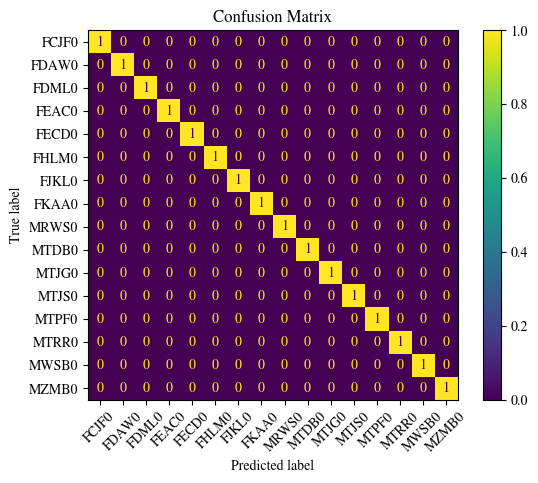

In [30]:
ConfusionMatrixDisplay(
    confusion_matrix(actual, predictions), display_labels=speakers
).plot()
plt.title("Confusion Matrix")
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.show()

Made with ❤️ by [Muhammad Umer](https://github.com/muhd-umer)